In [21]:
import pandas as pd
import json
# Đường dẫn đến tệp dữ liệu CSV
file_path = 'csv/Combined_All_Files.csv'

# Đọc tệp CSV vào DataFrame
data = pd.read_csv(file_path)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88633 entries, 0 to 88632
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  88633 non-null  object 
 1   NDVI          88633 non-null  float64
 2   year          88633 non-null  float64
 3   .geo          88633 non-null  object 
dtypes: float64(2), object(2)
memory usage: 2.7+ MB


In [22]:
data['.geo'] = data['.geo'].apply(json.loads)

# Trích xuất tọa độ từ object sau khi chuyển đổi
data['longitude'] = data['.geo'].apply(lambda geo: geo['coordinates'][0])
data['latitude'] = data['.geo'].apply(lambda geo: geo['coordinates'][1])

In [23]:
data

,system:index,NDVI,year,.geo,longitude,latitude
0,0_0,0.727862,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.623687,20.307630
1,0_1,0.730656,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.623956,20.307630
2,0_2,0.728212,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.624226,20.307630
3,0_3,0.726606,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.624495,20.307630
4,0_4,0.704954,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.624765,20.307630
...,...,...,...,...,...,...
88628,1_2335,0.350549,2000.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.636353,20.319487
88629,1_2336,0.348650,2000.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.636622,20.319487
88630,1_2337,0.348749,2000.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.636892,20.319487
88631,1_2338,0.344462,2000.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.637161,20.319487


In [38]:
data.head()

,system:index,NDVI,year,.geo,longitude,latitude
0,0_0,0.727862,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.623687,20.30763
1,0_1,0.730656,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.623956,20.30763
2,0_2,0.728212,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.624226,20.30763
3,0_3,0.726606,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.624495,20.30763
4,0_4,0.704954,2001.0,"{'geodesic': False, 'type': 'Point', 'coordina...",105.624765,20.30763


In [24]:
# Bước 1: Tạo các cột `pixel_id` và `year_number` từ `system:index`
data[['year_number', 'pixel_id']] = data['system:index'].str.split('_', expand=True)
data['year_number'] = data['year'].astype(int)
data['pixel_id'] = data['pixel_id'].astype(int)

# Bước 2: Lấy giá trị duy nhất của `longitude` và `latitude` cho mỗi pixel_id
coords = data[['pixel_id', 'longitude', 'latitude']].drop_duplicates(subset='pixel_id')

# Bước 3: Tạo DataFrame dạng pivot với NDVI theo năm
pivot_df = data.pivot(index='pixel_id', columns='year_number', values='NDVI')

# Bước 4: Thêm `longitude` và `latitude` vào `pivot_df`
pivot_df = pivot_df.merge(coords, on='pixel_id', how='left')

# Bước 5: Đổi tên các cột năm (nếu cần)
pivot_df.columns = [f'Year_{col}' if isinstance(col, int) else col for col in pivot_df.columns]


In [25]:
pivot_df.reset_index(inplace=True)
pivot_df.head()
pivot_df.to_csv('pivot_data.csv', index=False)

In [14]:
import xarray as xr
data = pivot_df.dropna()
years = [int(col.split('_')[1]) for col in data.columns if col.startswith("Year_")]
pixel_ids = data['pixel_id']

# Chuyển đổi DataFrame sang xarray.Dataset
ds = xr.Dataset(
    {
        "NDVI": (["pixel_id", "year"], data.drop(columns="pixel_id").values)
    },
    coords={
        "pixel_id": pixel_ids,
        "time": years
    }
)

# Hiển thị Dataset
print(ds)

NameError: name 'pivot_df' is not defined

In [28]:
# Đọc tệp CSV vào DataFrame
data = pd.read_csv("pivot_data.csv")  
years = [int(col.split('_')[1]) for col in data.columns if col.startswith("Year_")]
pixel_ids = data['pixel_id']

ds = xr.Dataset(
    {
        "NDVI": (["pixel_id", "year"], data.drop(columns="pixel_id").values)
    },
    coords={
        "pixel_id": pixel_ids,
        "time": years
    }
)

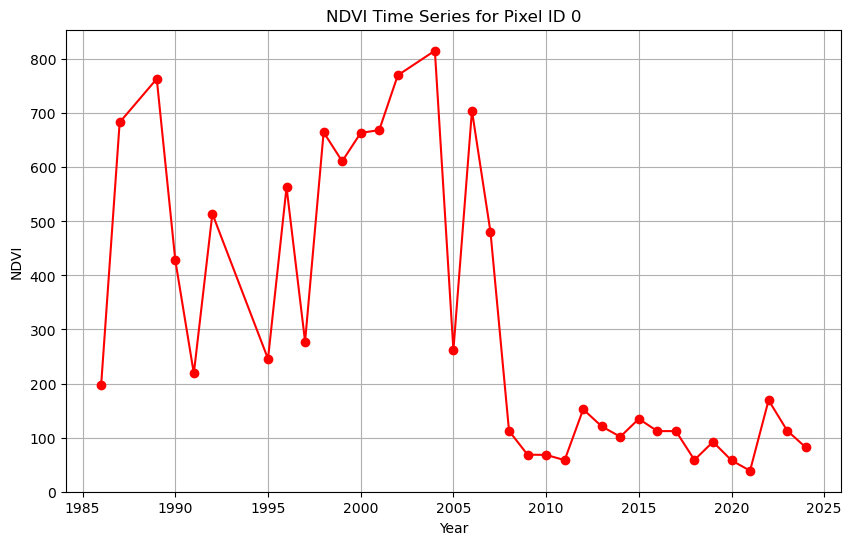

In [29]:
import matplotlib.pyplot as plt

# Giả sử bạn đã đọc dữ liệu từ 'pivot_data.csv' và đã tạo xarray Dataset ds

# Chọn một pixel_id để vẽ biểu đồ (ví dụ pixel_id đầu tiên)
pixel_id = ds.pixel_id[0].values

# Lấy giá trị NDVI của pixel_id này qua các năm
ndvi_values = ds["NDVI"].sel(pixel_id=pixel_id).values

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(years, ndvi_values, marker='o', linestyle='-', color='red')
plt.title(f"NDVI Time Series for Pixel ID {pixel_id}")
plt.xlabel("Year")
plt.ylabel("NDVI")
plt.grid(True)
plt.show()

In [1]:
from dask.distributed import Client

In [2]:
client = Client("tcp://127.0.0.1:5763")
print(client)  # Hiển thị thông tin cluster

<Client: 'tcp://10.244.0.14:8786' processes=3 threads=24, memory=22.97 GiB>


In [12]:
import tarfile
import rasterio

# Mở tệp tar
tar_file = 'data/LT05_L2SP_127045_19860701_20200917_02_T1.tar'
with tarfile.open(tar_file, 'r') as tar:
    tar.list()  # Liệt kê nội dung trong tar file
    tif_files = [file for file in tar.getnames() if file.endswith('.TIF')]
    for tif_file in tif_files:
        tar.extract(tif_file, path=f'data/LT05_L2SP_127045_19860701_20200917_02_T1')  # Giải nén từng tệp .tif


?rw-r--r-- root/root      34727 2024-11-27 14:20:05 LT05_L2SP_127045_19860701_20200917_02_T1_ANG.txt 
?rw-r--r-- root/root      13057 2024-11-27 14:20:06 LT05_L2SP_127045_19860701_20200917_02_T1_MTL.json 
?rw-r--r-- root/root      13988 2024-11-27 14:20:06 LT05_L2SP_127045_19860701_20200917_02_T1_MTL.txt 
?rw-r--r-- root/root      20476 2024-11-27 14:20:06 LT05_L2SP_127045_19860701_20200917_02_T1_MTL.xml 
?rw-r--r-- root/root    1960377 2024-11-27 14:20:06 LT05_L2SP_127045_19860701_20200917_02_T1_QA_PIXEL.TIF 
?rw-r--r-- root/root     454131 2024-11-27 14:20:06 LT05_L2SP_127045_19860701_20200917_02_T1_QA_RADSAT.TIF 
?rw-r--r-- root/root    7722913 2024-11-27 14:20:06 LT05_L2SP_127045_19860701_20200917_02_T1_SR_ATMOS_OPACITY.TIF 
?rw-r--r-- root/root   66736879 2024-11-27 14:20:08 LT05_L2SP_127045_19860701_20200917_02_T1_SR_B1.TIF 
?rw-r--r-- root/root   62353134 2024-11-27 14:20:10 LT05_L2SP_127045_19860701_20200917_02_T1_SR_B2.TIF 
?rw-r--r-- root/root   64664252 2024-11-27 14:20:11 L

In [11]:
import os
import tarfile
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
from rasterio.mask import mask

# Mở tệp tar và giải nén các tệp .TIF
tar_file = 'data/LT05_L2SP_127045_19860701_20200917_02_T1.tar'
with tarfile.open(tar_file, 'r') as tar:
    tif_files = [file for file in tar.getnames() if file.endswith('.TIF')]
    for tif_file in tif_files:
        tar.extract(tif_file, path=f'data/LT05_L2SP_127045_19860701_20200917_02_T1')  # Giải nén từng tệp .tif

# Tạo thư mục đầu ra cho COG nếu chưa tồn tại
output_dir = "output_cog"
os.makedirs(output_dir, exist_ok=True)

# Tạo Polygon từ tọa độ của bạn (tọa độ là danh sách các điểm [longitude, latitude])
coords = [
    (105.312544, 21.519839),
    (105.548750, 21.597749),
    (105.807615, 21.342149),
    (105.732084, 21.189216),
    (105.474040, 21.129934)
]
polygon = Polygon(coords)

# Chuyển Polygon thành GeoDataFrame (EPSG:4326 cho các tọa độ là lat, lon)
gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs="EPSG:4326")

# Tạo danh sách để lưu trữ các band
all_bands = {}

# Duyệt qua các tệp .tif để đọc tất cả các band
for tif_file in tif_files:
    tif_path = f'data/LT05_L2SP_127045_19860701_20200917_02_T1/{tif_file}'
    
    with rasterio.open(tif_path) as src:
        # Kiểm tra CRS của ảnh và chuyển đổi CRS của polygon nếu cần
        if src.crs != "EPSG:4326":
            gdf = gdf.to_crs(src.crs)

        # Cắt ảnh theo polygon đã chuyển đổi CRS
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        
        band_name = tif_file.split('.')[0].split('T1_')[1]
        # Lưu trữ band vào danh sách (mỗi band là một mảng NumPy)
        all_bands[band_name] = out_image

# Kiểm tra nếu tất cả các band đã được đọc
# Nếu có ít nhất 1 band, tiếp tục gộp và lưu
if all_bands:
    # Lấy metadata từ band đầu tiên để cập nhật
    with rasterio.open(f'data/LT05_L2SP_127045_19860701_20200917_02_T1/{tif_files[0]}') as src:
        out_meta = src.meta
    # Cập nhật metadata để phù hợp với tất cả các band
    out_meta.update({
        "driver": "GTiff", 
        "dtype": "uint16",  # Kiểu dữ liệu của ảnh
        "nodata": None,     # Nếu không có NoData, bạn có thể để None
        "count": len(all_bands),  # Số lượng band (nếu bạn có nhiều band)
        "crs": src.crs,     # CRS của ảnh (có thể là EPSG:32648 hoặc một CRS khác)
        "transform": out_transform,  # Biến đổi affine cho ảnh cắt
        "tiled": True,      # Tạo ảnh theo kiểu tiling
        "blockxsize": 512,  # Kích thước block theo chiều ngang
        "blockysize": 512,  # Kích thước block theo chiều dọc
        "compress": "lzw",  # Nén ảnh với LZW
        "predictor": 2,     # Dùng predictor cho ảnh có giá trị giống nhau
        "overviews": "YES", # Tạo overviews (ảnh thu nhỏ) cho ảnh
    })

    # Tạo đường dẫn mới để lưu ảnh COG
    output_file = os.path.join(output_dir, f'cog_multiband.tif')

    # Lưu ảnh với tất cả các band vào GeoTIFF (COG)
    with rasterio.open(output_file, 'w', **out_meta) as dest:
        for i, (band_name, band_data) in enumerate(all_bands.items()):
            # Ghi band vào ảnh
            dest.write(band_data.squeeze(), i + 1)  # Ghi tất cả các band vào tệp
            # Lưu tên band vào metadata
            dest.set_band_description(i + 1, band_name)  # Gán tên cho band

        print(f"Đã tạo COG với nhiều band và tên band từ tệp: {output_file}")
else:
    print("Không có band nào được đọc từ các tệp .TIF.")


Đã tạo COG với nhiều band và tên band từ tệp: output_cog\cog_multiband.tif


In [15]:
import rasterio

cog_file = 'output_cog/cog_multiband.tif'

# Mở ảnh COG
with rasterio.open(cog_file) as src:
    # In thông tin metadata của ảnh
    print("Metadata:", src.profile)
    
    # Lấy số lượng band trong tệp
    num_bands = src.count
    print(f"Số lượng band: {num_bands}")

    for i in range(1, num_bands + 1):
        # Đọc band i
        band_data = src.read(i)
        band_name = src.descriptions[i-1]
        print(band_name)
        print(band_data)


Metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7741, 'height': 6941, 'count': 19, 'crs': CRS.from_epsg(32648), 'transform': Affine(30.0, 0.0, 532365.0,
       0.0, -30.0, 2388405.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}
Số lượng band: 19
QA_PIXEL
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
QA_RADSAT
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SR_ATMOS_OPACITY
[[55537 55537 55537 ... 55537 55537 55537]
 [55537 55537 55537 ... 55537 55537 55537]
 [55537 55537 55537 ... 55537 55537 55537]
 ...
 [55537 55537 55537 ... 55537 55537 55537]
 [55537 55537 55537 ... 55537 55537 55537]
 [55537 55537 55537 ... 55537 55537 55537]]
SR_B1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
SR_B2
[[0 0

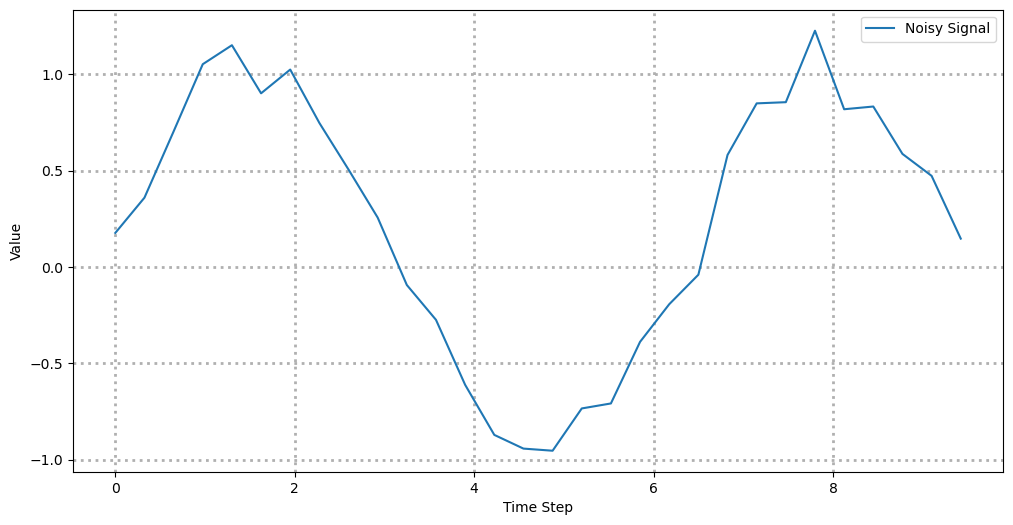

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

np.random.seed(0)
x = np.linspace(0, 3 * np.pi, 30)
y = np.sin(x) + np.random.normal(0, 0.1, x.size)

plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Noisy Signal')
plt.grid(lw=2,ls=':')
plt.xlabel('Time Step')
plt.ylabel("Value")
plt.legend()
plt.show()

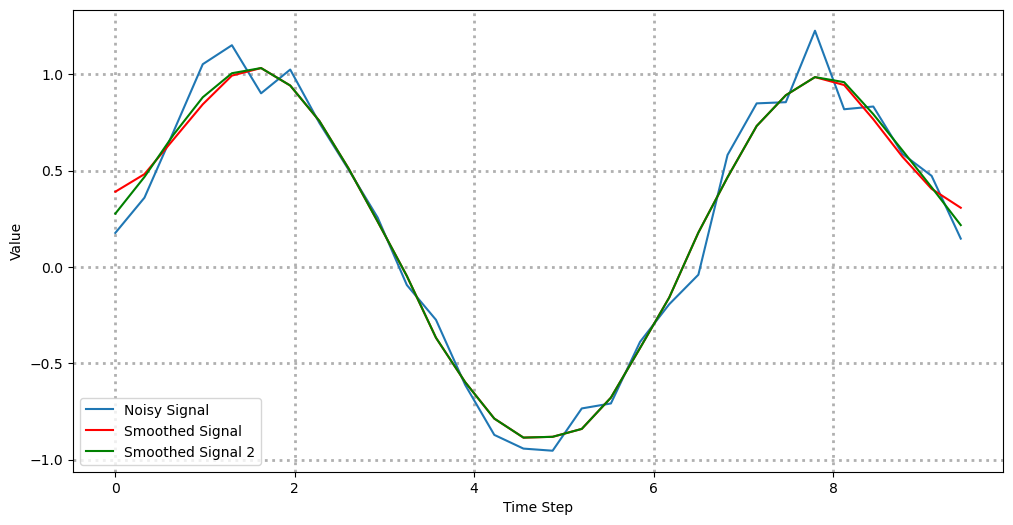

In [5]:
window_size = 11
poly_order = 3
y_smooth = savgol_filter(y, window_size, poly_order, mode = 'wrap')
y_smooth2 = savgol_filter(y, window_size, poly_order, mode = 'constant')
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Noisy Signal')
plt.plot(x, y_smooth, label='Smoothed Signal', color='red')
plt.plot(x, y_smooth2, label='Smoothed Signal 2', color='green')
plt.grid(lw=2,ls=':')
plt.xlabel('Time Step')
plt.ylabel("Value")
plt.legend()
plt.show()

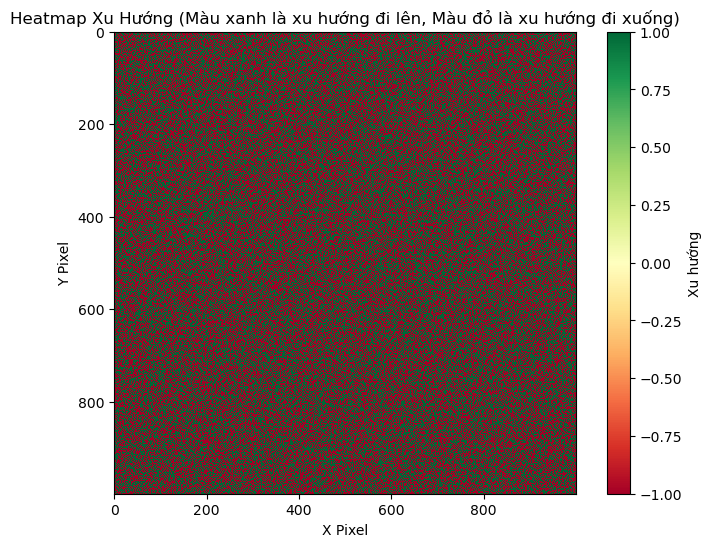

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo dữ liệu ngẫu nhiên cho xu hướng đi lên (màu xanh) và đi xuống (màu đỏ)
np.random.seed(0)
n = 1000  # Kích thước ma trận (10x10)
slopes = np.random.randn(n, n)  # Tạo ma trận ngẫu nhiên với các giá trị có phân phối chuẩn

# Tạo bản đồ xu hướng với màu sắc: màu đỏ cho xu hướng đi xuống, màu xanh cho xu hướng đi lên
trend_map = np.zeros_like(slopes)

# Gán giá trị cho màu sắc: nếu độ dốc dương thì màu xanh, nếu độ dốc âm thì màu đỏ
trend_map[slopes > 0] = 1  # Màu xanh cho xu hướng đi lên
trend_map[slopes < 0] = -1  # Màu đỏ cho xu hướng đi xuống

# Vẽ heatmap với cmap 'RdYlGn' (Red-Yellow-Green)
plt.figure(figsize=(8, 6))
plt.imshow(trend_map, cmap='RdYlGn', interpolation='nearest')
plt.colorbar(label='Xu hướng')  # Thanh màu biểu thị xu hướng
plt.title('Heatmap Xu Hướng (Màu xanh là xu hướng đi lên, Màu đỏ là xu hướng đi xuống)')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')

# Hiển thị
plt.show()


In [48]:
import pandas as pd
data = response.json()['result']
# Tách dữ liệu từ JSON
years = data["LandTrendr"][0]  # Danh sách năm
values = [-v for v in data["LandTrendr"][1]]  # Danh sách các giá trị tương ứng

# Chuyển đổi dữ liệu thành dạng bảng
df = pd.DataFrame(values).T  # Chuyển danh sách giá trị thành DataFrame và xoay cột
df.columns = [f"Year_{year}" for year in years]  # Đặt tên cột theo năm
df.insert(0, "pixel_id", range(len(df)))  # Thêm cột pixel_id
df.to_csv('pivot_data.csv', index=False)
df.head()

,pixel_id,Year_1986,Year_1987,Year_1988,Year_1989,Year_1990,Year_1991,Year_1992,Year_1993,Year_1994,...,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Year_2023,Year_2024
0,0,834.726535,874.352063,707.006369,876.133599,657.276995,350.859107,814.367161,847.627737,524.025728,...,757.13051,837.45583,862.007168,875.0,898.422304,891.312817,886.510081,898.734177,902.552204,897.736144


In [8]:
response.json()['result']['LandTrendr'][0]
response.json()['result']['LandTrendr'][1]

[-242.44293645897594,
 -258.55608293779665,
 -617.4261392088132,
 -391.6028518616319,
 -195.2264381884945,
 -534.4262295081967,
 -218.07786550503675,
 -463.6686390532544,
 -370.25014321176246,
 -570.6666666666666,
 -773.081657775954,
 -671.2975098296199,
 -705.6688075956437,
 -718.4604419101925,
 -793.8487115544473,
 -417.26751710112774,
 -698.8146551724138,
 -475.8778190122752,
 -541.0910793725124,
 -549.0790394031243,
 -329.1028446389497,
 -741.6372042425891,
 -395.70277529095796,
 -779.2559743779256,
 -586.01856908793,
 -623.1643114436132,
 -571.830985915493,
 -859.4956253216676,
 -507.0093457943925,
 -651.4334374112972,
 -263.4920634920635,
 -186.12716763005778,
 -345.6536618754278,
 -433.49536014140523,
 -549.3917274939173]

In [1]:
import pandas as pd
import glob

# Đường dẫn đến thư mục chứa các file CSV
folder_path = "csv/"  # Thay bằng đường dẫn thư mục của bạn. VD: "./data/"

# Tìm tất cả file CSV trong thư mục
csv_files = glob.glob(f"{folder_path}/*.csv")

# Kiểm tra danh sách file được tìm thấy
print("Danh sách file được tìm thấy:")
for file in csv_files:
    print(file)

# Đọc và ghép tất cả các file CSV
df_list = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

# Lưu file CSV sau khi ghép
output_file = f"{folder_path}/Combined_All_Files.csv"
combined_df.to_csv(output_file, index=False)

print(f"Đã ghép xong! File kết quả được lưu tại: {output_file}")


Danh sách file được tìm thấy:
csv\NDVI_Pixels_Time_Series_All_Years01_02.csv
csv\NDVI_Pixels_Time_Series_All_Years03_04.csv
csv\NDVI_Pixels_Time_Series_All_Years05_06.csv
csv\NDVI_Pixels_Time_Series_All_Years07_08.csv
csv\NDVI_Pixels_Time_Series_All_Years09_10.csv
csv\NDVI_Pixels_Time_Series_All_Years11_12.csv
csv\NDVI_Pixels_Time_Series_All_Years13_14.csv
csv\NDVI_Pixels_Time_Series_All_Years15_16.csv
csv\NDVI_Pixels_Time_Series_All_Years17_18.csv
csv\NDVI_Pixels_Time_Series_All_Years19_20.csv
csv\NDVI_Pixels_Time_Series_All_Years21_22.csv
csv\NDVI_Pixels_Time_Series_All_Years23_24.csv
csv\NDVI_Pixels_Time_Series_All_Years87_88.csv
csv\NDVI_Pixels_Time_Series_All_Years89_90.csv
csv\NDVI_Pixels_Time_Series_All_Years91_92.csv
csv\NDVI_Pixels_Time_Series_All_Years93_94.csv
csv\NDVI_Pixels_Time_Series_All_Years95_96.csv
csv\NDVI_Pixels_Time_Series_All_Years97_98.csv
csv\NDVI_Pixels_Time_Series_All_Years99_00.csv
Đã ghép xong! File kết quả được lưu tại: csv//Combined_All_Files.csv


In [32]:
import pandas as pd
import numpy as np
import xarray as xr
data = pd.read_csv("pivot_data.csv") 
data.replace(["", "NA", "null", "-"], np.nan, inplace=True)
years = [int(col.split('_')[1]) for col in data.columns if col.startswith("Year_")]
pixel_ids = data['pixel_id']

ds = xr.Dataset(
    {
        "NDVI": (["pixel_id", "time"], data.drop(columns=["pixel_id", "longitude", "latitude", "index"]).values)
    },
    coords={
        "pixel_id": pixel_ids,
        "time": years
    }
)


ds_filled = ds.interpolate_na(dim="time", method="linear").ffill(dim="time").bfill(dim="time")
df_interpolated = ds_filled.to_dataframe().reset_index()
df_interpolated.to_csv("interpolated_ndvi.csv", index=False)